In [728]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from scipy.stats import kendalltau

In [729]:
import time

import numpy as np
import matplotlib as plt

from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Reading the excel data into different data frames;

In [730]:
player_df = pd.read_excel('train_data.xlsx', sheet_name='Player')
point_df = pd.read_excel('train_data.xlsx', 'Points')

## Data Analysis 

Checking for any type of abnormalities by utilizing pandas' "groupby";

In [731]:
point_df.groupby(['Season']).count()



,Club,Points
Season,,
2007,18,18
2008,18,18
2009,17,17
2010,18,18
2011,18,18
2012,18,18
2013,18,18
2014,18,18
2015,18,18


Removing data points for Ankaraspor in the year 2009 since they do not have any points that year

In [732]:
boolean = (player_df['Season']==2009) & (player_df['Club']=='Ankaraspor')
boolean = [not i for i in boolean]
player_df = player_df[boolean]

To better understand the data we use .describe(). Results are as follows:

In [733]:
player_df[['Age','Foreign','Multinational','Market Value']].describe()

,Age,Foreign,Multinational,Market Value
count,4761.000000,4761.000000,4761.000000,4.761000e+03
mean,25.521109,0.501575,0.278723,1.722757e+06
std,4.095758,0.500050,0.448418,2.234580e+06
min,14.000000,0.000000,0.000000,2.500000e+04
25%,23.000000,0.000000,0.000000,4.500000e+05
50%,26.000000,1.000000,0.000000,1.000000e+06
75%,28.000000,1.000000,1.000000,2.000000e+06
max,38.000000,1.000000,1.000000,3.200000e+07


   As it can be seen above the average age of the players among all of the seasons provided is 25.521 with a standard deviation of 4.09 . In addition, half of the players are foreign and approximately half of these players are multinational. Average market value of a player who played in Turkish Super League between 2007-2015 is 1.72 M Euro. To better understand the data we investigate the distrubitions and time trends in the variables. Below in the first figure you can see the histogram of the Market Value of the players. In the second one you can see the histogram of the age of the players. In the third and the fourth figures you can find the time trends in these variables. As you can see there is an upward trand in both Market Value and Age.

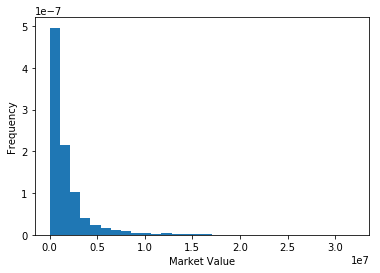

In [734]:
import matplotlib.pyplot as plt
%matplotlib inline
x = player_df['Market Value']
plt.hist(x, normed=True, bins=30)
plt.ylabel('Frequency');
plt.xlabel('Market Value');

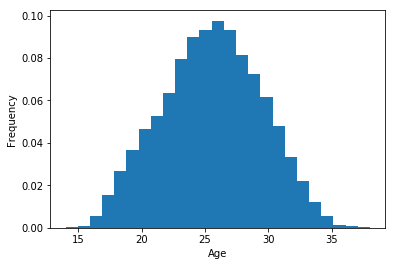

In [735]:
%matplotlib inline
x = player_df['Age']
plt.hist(x, normed=True, bins=25)
plt.ylabel('Frequency');
plt.xlabel('Age');

In order to give some aggregation to the data and see the time trends we group the data and analyze the resulting dataframes.

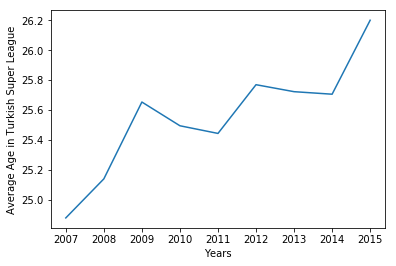

In [736]:
grouped_df = player_df.groupby(['Season', 'Club'])
dum = grouped_df.mean()['Age']
dum = dum.groupby('Season').mean()
plt.plot(dum)
plt.ylabel('Average Age in Turkish Super League')
plt.xlabel('Years')
plt.show()

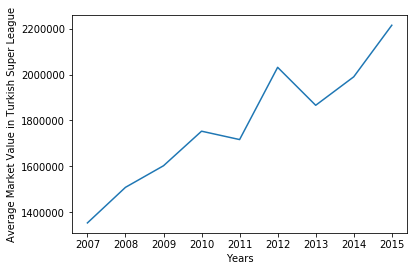

In [737]:
dum = grouped_df.mean()['Market Value']
dum = dum.groupby('Season').mean()
plt.plot(dum)
plt.ylabel('Average Market Value in Turkish Super League')
plt.xlabel('Years')
plt.show()

# Feature Creation

We think that age is a measure of strength and energy of a player, therefore a squad with more young and energetic players can endure the difficulty of league throughout a season. General age average is a measure of youth of a squad, so we thought that age average of each team throughout seasons would be a good feature to predict which team can handle the hardness of a tough season.
We also think that an experienced leader would have an influence over the team that intends to achieve higher goals throughout a season. Moreover, a young player who is able to play a team indicates that the squad is lack of adequate players, meaning team is financially not so powerful enough to design its squad with experienced and relatively young and energetic players. Therefore we though that these three age related features would fit well to predict such an estimation.

In [738]:
x1 = grouped_df.mean()['Age']   # age mean
x1 = x1.rename('Average Age')
x2 =  grouped_df.max()['Age']   # oldest player 
x2 = x2.rename('Max age')
x3 =  grouped_df.min()['Age']   # youngest player
x3 = x3.rename('Min age')

We observed that a team with high quality players would be more successful. Market value can be seen as a metric of quality, so that a player in form will have higher market value. A generalized team average of market values of players shows a significant effect on predictions on a season. Therefore it is a measure of team's squad quality, and we think that it would be a good feature to take into account. However, some teams have more players than others, in purpose of widening the squad, resulting the average quality of squad. So, it may not be as good as it is thought it is.

In [739]:
x4 = grouped_df.mean()['Market Value']  # mean of team MV
x4 = x4.rename('Average Market Value')


We examined that a star player of a team can carry the team higher than expected, so it is possible to build a team plan over a star player. Therefore we suspected that star players of each team can have influence over the season. A accountable measure of being a star player is market value. However it may be incorrect for teams that are built over plenty of average players.

In [740]:
x5 = grouped_df.max()['Market Value']   # star player 
x5 = x5.rename('Max Market Value')

We suspect that the player that has the lowest market value can be an indicator. It is a measure of how expensive a team's squad is, corresponding to the market value threshold of a squad. Lowest value is a distinguishable feature, therefore we think that it is a good feature to predict.

In [741]:
x6 = grouped_df.min()['Market Value']   # the worst player
x6 = x6.rename('Min Market Value')

We thought that age average is a parameter that may not fit a quadratic relationship. Therefore, in order to see its effects clearly, we preferred to take its square, so it would have more influence over predictions. Distibution of age squared is wider than age average, therefore can imply more detailed examination. 

In [742]:
x7 = x1**2                              # Age squared
x7 = x7.rename('Age Squared')

A squad's total market value is also a good parameter to read on, which can show us the quality of the squad according to their financial values. It is directly related to players' form rating and quality, therefore shows the aggregate quantity of squad's quality. We picked this as feature because of this behavior may fit an estimated season analysis. However, it may be incorrect for those teams which have more players, directly increasing the total market value by number of players.

In [743]:
x66 = grouped_df['Market Value'].sum()   # total Market Value
x66 = x66.rename('Total MV')

It can be said that a team with distributed age structure is better than the one that has only olders or youngers. Older based teams are not capable of enduring the hard tempo of a full season due to lack of energetic players, whereas younger based teams are lack of experience and cold-blood situation-saver players. A synthesis of young and old mixed uniformly is a key of squad balance throughout a season. Therefore we thought that standard deviation of age of a squad is a feature to take into account in predicting a test season. 

In [744]:
x77 = grouped_df.std()['Age']            # Proxy for age Distribution
x77 = x77.rename('Age Standard Deviation')

We suspect that number of players in a given team in a given year is a variable that helps explaining the variation of points earned in that given year. Availability of different players is a strength for the coach as he can select different players for different circumstances.In addition when the team is tired, availability of different players can affect the outcome of matches. So we thought that it might be a factor contributing to the succes of a team. 

In [745]:
x9 = grouped_df.count()['Player']      # Kadro Genisligi 
x9 = x9.rename('Squad Width')



We speculate that in addition to mean market value, the standard deviation of the market value(x8) of players in a team in a given year would behave like a proxy for the balanced distribution of players. We tested that the balanced distribution(high standard deviation) or a compact distribution(low standard deviation) may affect the succes of a team in terms of points earned in a season.

Also, the average market value of the most 5 expensive players could be a factor in explaining the points that a club earn in a given year. In the cases that clubs may have too many cheap players which can decrease the mean market value of a team as a whole, x10 would perform  better.

In addition to the features related to market values, we also tried the median of Market value(x17) since the distribution of Market Value is left skewed.

In [746]:
x8 = grouped_df.std()['Market Value']   # Proxy for Market Value Distribution
x8 = x8.rename('MV Standard Deviation')

x10 = (grouped_df['Market Value'].nlargest(5)).to_frame()  # Quantile MV
x10 = x10.reset_index().groupby(['Season','Club']).sum()
del x10['level_2']
x10 =x10['Market Value'] 
x10 = x10.rename('Quantile MV')

x17= grouped_df.median()['Market Value']


In Turkish Super League probably one of the most important and discussed issue is the number of foreign players that teams has. We hypothesized that the total number of foreign players(x12) may affect the overall performance of a given team in a given year. However since the teams total player counts(Squad Widths) may differ this feature did not worked so well. In addition, a lot of poorer clubs can afford cheaper foreign players which increases their total number of foreign players. As a complementary approach, we speculated that the Market Value of these foreign players(x13) and the fraction of the squad(x11) that are foreign players can affect the end-of-season rankings. Finally, we observed that sometimes some foreign players( like Van Persie )come to teams when they are old but do not perform well despite the fact that their market values are high. So in order to take this fact into account we constuct the feature(x14) that look at the average age of the foreign players. These features improved the performance in explaining the variance in the dependent variable('points' in that case).

In [747]:
x11 = grouped_df['Foreign'].sum() / grouped_df['Player'].count() # Kadrodaki yabanci orani
x11 = x11.rename('Foreign Ratio')

x12 = grouped_df['Foreign'].sum()             # Kadroda Yabanci sayisi (cok kotu calisiyor)
x12 = x12.rename('Foreign Number')

x13 = pd.DataFrame(player_df.groupby(['Season', 'Club','Foreign'])['Market Value'].mean())
x13 = x13.reset_index()
x13 = x13[x13['Foreign']==1]
x13 = x13.set_index(['Season', 'Club'])
x13 = x13.drop(['Foreign'], axis = 1)      # Yabanci oyuncu MV ortalamasi

x14 = pd.DataFrame(player_df.groupby(['Season', 'Club','Foreign'])['Age'].mean())
x14 = x14.reset_index()
x14 = x14[x14['Foreign']==1]
x14 = x14.set_index(['Season', 'Club'])
x14 = x14.drop(['Foreign'], axis = 1)      # Yabanci oyuncu average age

In addition to players being foreign there is a belief that being multinational is a strong indicator of a player's ability. In the feature x15 and x16 we tried to capture this effect and tried to explain the variance in the dependent variable. x15 is constructed of total number of multinational players.Although it seems like a good proxy for multinationals in a team, it is a cardinal relationship. Since the total number of players can differ(squad width), x15 does a poor job in terms of performance. x16 tries to convert the carinal structure of x15 to an ordinal type of a relation. 

In [748]:
x15 = grouped_df.sum()['Multinational']   # Multinational oyuncu sayisi

x16 = grouped_df.sum()['Multinational'] / grouped_df['Foreign'].sum() # Multinational oyuncu / yabanci



Finally, we assert that being a big football club in terms of budget, number of supperters and a name that prevails in Turkish soccer community affects the points taken. We suggest that being one of the big 4 clubs in Turkey, namely Fenerbahce Galatasaray, Besiktas and Trabzon spor strongly affects the points taken in a given year. We try to catch this effect via the feateure 'aa'. Not surprisingly, this feature performs very well. 

In [749]:
xdum=x1.rename('Coef')
aa=pd.DataFrame(xdum*0).reset_index()
bol = (aa['Club']=='Fenerbahce') | (aa['Club']=='Besiktas') | (aa['Club']=='Galatasaray') | (aa['Club']=='Trabzonspor') 
aa['Coef']=bol
aa=aa.set_index(['Season','Club'])
aa=aa['Coef']


## Feature Selection

In order to select features we first came up with a benchmark model which is very simple. To be more specific we used the average age and the average market value of players and tested this benchmark feature set using season 2015 as test set. Then, we noted the out of sample R-Squared and the Tau for comparison of the features selected. Afterwards we tried to add features to see how these parameters behave among features added. For example, cardinal variables like 'Total market value', 'Squad with', 'Number of foreign players', 'Multinational player number' performed significantly bad according to the metrics we selected. We then tightened the candidate feature set according to this analysis. 


In [750]:

y = point_df.sort_values(['Season', 'Club'], ascending=True)
y = y.set_index(['Season', 'Club'])

list_of_series = [x1,x4,x5,x6,aa]
X = pd.concat(list_of_series, axis=1)




### Test set is the year 2015

In [751]:
X_train = X.loc[2007:2014]
X_test = X.loc[2015:]
y_train = y.loc[2007:2014]
y_test = y.loc[2015:]

final_model = LinearRegression(fit_intercept=False)
final_model.fit(X_train,y_train)

predictions = final_model.predict(X_test)
print(predictions)

def getKey(item):
      return item[1]
temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
converted_predictions = np.zeros((18,), dtype=int)
for i in range(0,17):
    converted_predictions[temp2[i][1][0]] = temp2[i][0]
print(converted_predictions)

deneme = np.array(y_test)
temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
y_test_rank = np.zeros((18,), dtype=int)
for i in range(0,17):
    y_test_rank[temp2[i][1][0]] = temp2[i][0]
print(y_test_rank)
print ('R-squared = %f' %final_model.score(X_test,y_test))
kendalltau(converted_predictions, y_test_rank)

[[46.84049848]
 [48.03229384]
 [43.154651  ]
 [78.34802425]
 [43.02767012]
 [49.35435389]
 [42.20485042]
 [78.08362424]
 [68.16598792]
 [40.11868768]
 [45.2403231 ]
 [49.62968994]
 [42.76623173]
 [44.50025534]
 [39.28996744]
 [45.17039657]
 [46.53902259]
 [57.73627213]]
[ 8  7 13  1 14  6 16  2  3 17 10  5 15 12  0 11  9  4]
[ 8  5  9  1 11  4 17  2  6 14 10  7 15  3  0 13 16 12]
R-squared = 0.475871


KendalltauResult(correlation=0.5947712418300655, pvalue=0.0005671197521065596)

### Test set is the year 2014 

In [752]:
X_train1 = X.loc[2007:2013]
X_train2 = X.loc[2015]
X_train= pd.concat([X_train1,X_train2], axis=0)
X_test = X.loc[2014]

y_train1 = y.loc[2007:2013]
y_train2 = y.loc[2015]
y_train= pd.concat([y_train1,y_train2], axis=0)
y_test = y.loc[2014]

final_model = LinearRegression(fit_intercept=False)
final_model.fit(X_train,y_train)

predictions = final_model.predict(X_test)
print (predictions)

def getKey(item):
      return item[1]
temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
converted_predictions = np.zeros((18,), dtype=int)
for i in range(0,17):
    converted_predictions[temp2[i][1][0]] = temp2[i][0]
print (converted_predictions)

deneme = np.array(y_test)
temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
y_test_rank = np.zeros((18,), dtype=int)
for i in range(0,17):
    y_test_rank[temp2[i][1][0]] = temp2[i][0]
print (y_test_rank)
print ('R-squared = %f' %final_model.score(X_train,y_train))
kendalltau(converted_predictions, y_test_rank)




[[44.50065418]
 [40.71282658]
 [62.91504077]
 [43.83016281]
 [45.20099149]
 [40.2009043 ]
 [74.84930877]
 [80.22699666]
 [38.23530421]
 [40.64778815]
 [41.42190955]
 [41.76894725]
 [43.74743715]
 [44.73564784]
 [41.89192202]
 [43.40702433]
 [47.13504259]
 [49.89416547]]
[ 8 15  3  9  6 17  2  1  0 16 14 13 10  7 12 11  5  4]
[12 17  3  5  4 11  2  1  9 10  0 16 13  8  7 14 15  6]
R-squared = 0.508780


KendalltauResult(correlation=0.35947712418300654, pvalue=0.037226296032875555)

Afterwards we utilized a leave one out approach to select the best feature set that consists of 4 features. We left the year 2014 out and trained the model using remaining years(2007-2013), in a way that maximizes the tau for 2014. Then we report the resulting features and their performances for the actual test set(year 2015). Note that the analysis is further improved via using different years as the left-out. And then select the feature sets that has the best performance among the years.

Here we need to mention that according to the results, the expectation that we have initially is realized. In addition, the initial ad-hoc selection of features (namely x1:'Mean Age' and x2:'Mean Market Value') to construct the aforementioned benchmark model, seems consistent as in the final feature set contains both of them.  The top Performer Features are as follows:


- x1 : 'Mean Age'
- x4 : 'Mean Market Value'
- x11 : 'Foreign fraction of players in the Squad'
- x16 : 'Multinational players' fraction in the foreign players'
- aa : 'Being a "big" football club'

Note that these selection of features not only performs better in the data that the model did not see before (Season:2015) but also performs reasonably well in the other seasons according to the parameters selected.

In [753]:
list_of_series= [x1,x2,x4,x5,x6,x77,x10,x11,aa,x16]

 Number of features per set is 4 

In [754]:
maxco=float() #max correlation
maxi=int()  #max i index
maxj=int()  #max j index
maxl=int()
maxm=int()

for i in range (0,10):  #loop for 14 features
    for j in range (0,10): #loop for 14 features
        for l in range (0,10):  #loop for 14 features
            for m in range (0,10): #loop for 14 features
                corlist=[]  #correlation list for 6 test years
                for u in range (0,5):  #loop for 6 test years
                    X = pd.concat([list_of_series[i],list_of_series[j],list_of_series[l],list_of_series[m]], axis=1)
                    X_train1 = X.loc[2007:2013-u]   #respectively chosen 4 features
                    X_train2 = X.loc[2014-u:2014]
                    X_train= pd.concat([X_train1,X_train2], axis=0)
                    X_test = X.loc[2014-u]

                    y_train1 = y.loc[2007:2013-u]
                    y_train2 = y.loc[2014-u:2014]
                    y_train= pd.concat([y_train1,y_train2], axis=0)
                    y_test = y.loc[2014-u]
                    final_model = LinearRegression(fit_intercept=False)
                    final_model.fit(X_train,y_train)
                    predictions = final_model.predict(X_test)

                    def getKey(item):
                        return item[1]
                    temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
                    temp2 = list(enumerate(temp1,1))
                    converted_predictions = np.zeros((18,), dtype=int)
                    for k in range(0,17):
                        converted_predictions[temp2[k][1][0]] = temp2[k][0]

                    deneme = np.array(y_test)
                    temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
                    temp2 = list(enumerate(temp1,1))
                    y_test_rank = np.zeros((18,), dtype=int)
                    for k in range(0,17):
                        y_test_rank[temp2[k][1][0]] = temp2[k][0]

                    corlist.append(kendalltau(converted_predictions, y_test_rank)[0]) #adding calculated corr to list
            tempco=sum(corlist) #correlation sum after 6 year test
            if tempco > maxco:  #changing max correlation sum indexes
                maxi=i
                maxj=j
                maxl=l
                maxm=m
                maxco=tempco

print(maxco)
print(maxi+1)
print(maxj+1)
print(maxl+1)
print(maxm+1)

2.032679738562092
1
3
8
10


Below we can see that adding 'aa' to the feature set decreases the performance of the feature set a little but decreases the standard deviation as well. So in order to have a more precise performance we included the 'Big Team' feature to the final set.

In [755]:
corlist=[]  #correlation list for 6 test years
i= 0#0 #x1
j= 2#2 #x4
l= 7#7#7 #3 #x5
m= 9#9 #9 #4 #x6
z= 8#8 #8 #aa
for u in range (0,5):  #loop for 6 test years
    X = pd.concat([list_of_series[i],list_of_series[j],list_of_series[l],list_of_series[m]], axis=1)
    X_train1 = X.loc[2007:2013-u]   #respectively chosen 4 features
    X_train2 = X.loc[2014-u:2014]
    X_train= pd.concat([X_train1,X_train2], axis=0)
    X_test = X.loc[2014-u]

    y_train1 = y.loc[2007:2013-u]
    y_train2 = y.loc[2014-u:2014]
    y_train= pd.concat([y_train1,y_train2], axis=0)
    y_test = y.loc[2014-u]
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    predictions = final_model.predict(X_test)

    def getKey(item):
        return item[1]
    temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
    temp2 = list(enumerate(temp1,1))
    converted_predictions = np.zeros((18,), dtype=int)
    for k in range(0,17):
        converted_predictions[temp2[k][1][0]] = temp2[k][0]

    deneme = np.array(y_test)
    temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
    temp2 = list(enumerate(temp1,1))
    y_test_rank = np.zeros((18,), dtype=int)
    for k in range(0,17):
        y_test_rank[temp2[k][1][0]] = temp2[k][0]

    corlist.append(kendalltau(converted_predictions, y_test_rank)[0]) #adding calculated corr to list
print (corlist)
print ('Total Performance without the feature aa %f' %sum(corlist))
print ('Standard Deviation of the performance without the feature aa %f' %np.std(corlist))

corlist=[]  #correlation list for 6 test years
for u in range (0,5):  #loop for 6 test years
    X = pd.concat([list_of_series[i],list_of_series[j],list_of_series[l],list_of_series[m], list_of_series[z]], axis=1)
    X_train1 = X.loc[2007:2013-u]   #respectively chosen 4 features
    X_train2 = X.loc[2014-u:2014]
    X_train= pd.concat([X_train1,X_train2], axis=0)
    X_test = X.loc[2014-u]

    y_train1 = y.loc[2007:2013-u]
    y_train2 = y.loc[2014-u:2014]
    y_train= pd.concat([y_train1,y_train2], axis=0)
    y_test = y.loc[2014-u]
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    predictions = final_model.predict(X_test)

    def getKey(item):
        return item[1]
    temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
    temp2 = list(enumerate(temp1,1))
    converted_predictions = np.zeros((18,), dtype=int)
    for k in range(0,17):
        converted_predictions[temp2[k][1][0]] = temp2[k][0]

    deneme = np.array(y_test)
    temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
    temp2 = list(enumerate(temp1,1))
    y_test_rank = np.zeros((18,), dtype=int)
    for k in range(0,17):
        y_test_rank[temp2[k][1][0]] = temp2[k][0]

    corlist.append(kendalltau(converted_predictions, y_test_rank)[0]) #adding calculated corr to list
print  (corlist)
print ('Total Performance with the feature aa %f' %sum(corlist))
print ('Standard Deviation of the performance with the feature aa %f' %np.std(corlist))

[0.25490196078431376, 0.24183006535947715, 0.24183006535947715, 0.607843137254902, 0.6862745098039217]
Total Performance without the feature aa 2.032680
Standard Deviation of the performance without the feature aa 0.198004
[0.2941176470588236, 0.281045751633987, 0.22875816993464054, 0.5816993464052289, 0.607843137254902]
Total Performance with the feature aa 1.993464
Standard Deviation of the performance with the feature aa 0.161796


### Trying the outcomes for the data that the model did not see (i.e 2015)

In [756]:
y = point_df.sort_values(['Season', 'Club'], ascending=True)
y = y.set_index(['Season', 'Club'])

list_of_series = [x1,x4,x11,x16,aa]
X = pd.concat(list_of_series, axis=1)

X_train = X.loc[2007:2014]
X_test = X.loc[2015:]
y_train = y.loc[2007:2014]
y_test = y.loc[2015:]

final_model = LinearRegression(fit_intercept=False)
final_model.fit(X_train,y_train)

predictions = final_model.predict(X_test)
print (predictions)

def getKey(item):
      return item[1]
temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
converted_predictions = np.zeros((18,), dtype=int)
for i in range(0,17):
    converted_predictions[temp2[i][1][0]] = temp2[i][0]
print (converted_predictions)

deneme = np.array(y_test)
temp1 = sorted(enumerate(deneme), key=getKey, reverse = True)
temp2 = list(enumerate(temp1,1))
y_test_rank = np.zeros((18,), dtype=int)
for i in range(0,17):
    y_test_rank[temp2[i][1][0]] = temp2[i][0]
print (y_test_rank)
print ('OOS R-squared = %f' %final_model.score(X_test,y_test))
print ('In Sample R-squared = %f' %final_model.score(X_train,y_train))
kendalltau(converted_predictions, y_test_rank)

[[46.26326583]
 [46.15812706]
 [43.31672423]
 [71.8585596 ]
 [45.64635989]
 [48.54957396]
 [42.56774166]
 [80.03311008]
 [71.27534424]
 [40.97793832]
 [43.72087513]
 [46.78468037]
 [42.97218744]
 [43.31525215]
 [39.5198886 ]
 [43.45833943]
 [46.04053588]
 [60.43551053]]
[ 7  8 13  2 10  5 16  1  3 17 11  6 15 14  0 12  9  4]
[ 8  5  9  1 11  4 17  2  6 14 10  7 15  3  0 13 16 12]
OOS R-squared = 0.381083
In Sample R-squared = 0.522720


KendalltauResult(correlation=0.542483660130719, pvalue=0.0016674135317840974)

 Adjusting the Design matrix for project evaluation

In [757]:
X_train = X.loc[2007:2015]
y_train = y.loc[2007:2015]

# Evaluation

In [758]:
# Fill this function to construct a data frame X that contains your final features extracted from the dataset
def construct_features(df):
    grouped_df = df.groupby(['Season', 'Club'])
    x1 = grouped_df.mean()['Age']
    x4 = grouped_df.mean()['Market Value']  # mean of team MV
    x4 = x4.rename('Average Market Value')
    x11 = grouped_df['Foreign'].sum() / grouped_df['Player'].count() # Kadrodaki yabanci orani
    x11 = x11.rename('Foreign Ratio')
    x16 = grouped_df.sum()['Multinational'] / grouped_df['Foreign'].sum() # Multinational oyuncu / yabanci

    xdum=x1.rename('Coef')
    aa=pd.DataFrame(xdum*0).reset_index()
    bol = (aa['Club']=='Fenerbahce') | (aa['Club']=='Besiktas') | (aa['Club']=='Galatasaray') | (aa['Club']=='Trabzonspor') 
    aa['Coef']=bol
    aa=aa.set_index(['Season','Club'])
    aa=aa['Coef']

    list_of_series = [x1,x4,x11,x16,aa]
    X = pd.concat(list_of_series, axis=1)
    
    return X


In [759]:
# Fill this function to construct a data frame y that contains the labels of the test data
# rawd data --->> ranking 
def construct_labels(df):
    def convert_points_to_predictions(predictions):
        def getKey(item):
            return item[1]
        temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
        temp2 = list(enumerate(temp1,1))
        converted_predictions = np.zeros((len(predictions),), dtype=int)
        for i in range(0,len(predictions)-1):
            converted_predictions[temp2[i][1][0]] = temp2[i][0]
        return converted_predictions
    y = df.sort_values(['Season', 'Club'], ascending=True)
    y = y.set_index(['Season', 'Club'])
    y = y['Points']
    y = convert_points_to_predictions(y)
    return y

In [760]:
# If you try to choose to predict points instead of rankings then you should implement this function as well
# to generate rankings. If you predict the rankings directly, you can leave this function as it is.
def convert_points_to_predictions(predictions):
    def getKey(item):
        return item[1]
    temp1 = sorted(enumerate(predictions), key=getKey, reverse = True)
    temp2 = list(enumerate(temp1,1))
    converted_predictions = np.zeros((len(predictions),), dtype=int)
    for i in range(0,len(predictions)-1):
        converted_predictions[temp2[i][1][0]] = temp2[i][0]
    return converted_predictions

In [761]:
# This function will evaluate your features test performance using the ranking predictions
def compute_test_score(outfile_name):
    # X_test should contain the feature you engineered and y_test should contain the corresponding labels, which are team rankings 
    X_test = construct_features(pd.read_excel('test_data.xlsx',sheet_name='Player'))
    y_test = construct_labels(pd.read_excel('test_data.xlsx','Points'))
    # This is the regression model you will use
    final_model = LinearRegression(fit_intercept=False)
    final_model.fit(X_train,y_train)
    # Your model's predictions will be stored in this array
    predictions = final_model.predict(X_test)
    # Your model can predict either points or rankings. If necessary, change the function above
    #! SENELIK MI TEST DATASI 
    predictions = convert_points_to_predictions(predictions)
    # Your performance on the test set
    tau, _ = kendalltau(predictions, y_test)
    # Print tau both to file and screen
    print(tau)
    f = open(outfile_name, 'w')
    f.write(str(tau))
    f.close()

#outfile name should have the format ID1_ID2_ID3.txt
outfile_name = '2016749060-2014401015-2017701117.txt'
compute_test_score(outfile_name)

0.5555555555555556
